# P3 Matching Pipeline

**Note: If you cannot get any parts of this assignment working, you should include (small) blocks of partially implemented code in your writeup; we will use this for evaluating partial credit.**

You are *required* to LaTeX your solutions to this assignment and use the 10pt, 2-column `ieeeconf` template. You can find the template [on Overleaf](https://www.overleaf.com/latex/templates/preparation-of-papers-for-ieee-sponsored-conferences-and-symposia/zfnqfzzzxghk); Overleaf is an online LaTeX editor with a free tier, so feel free to use that service to compose your writeups. It is perhaps the easiest option, particularly if you are not as familiar with LaTeX. You are allowed to work in small groups (2 or 3 students), but your solutions and your writeup should be your own.

With these homework assignments, I expect that your solutions will be written as if they are research papers: though the content is not "new", you should be trying to convince me through your writing that you have implemented and understand the algorithms. You should write in full sentences. When appropriate, comment on when the algorithms succeed or fail and where they are more or less effective; include numbers/metrics (quantitative) in addition to discussion (qualitative) whenever possible. If I ask you to compare two algorithms or approaches, you should be thorough in your comparison, using numbers in addition to qualitative explanations whenever possible. Your response should include a discussion (in words) about how they are similar and different, but might also include a quantitative comparison if possible.

Just like in a published paper, you should not include code snippets in your writeup unless it is explicitly asked for or you think it helps you explain your results or answer the question. **I will ask you to submit both the PDF of your writeup *and* a .zip file containing your code (which may be a modified form of this Jupyter notebook) on Blackboard**. Though it would be nice if your code were cleaned up and nicely formatted/commented, we will not likely execute your code unless we are skeptical for academic integrity reasons. We may also use your code to evaluate partial credit on multi-part assignments.

## P3.1 Scaling and Rotating Patches

In the previous programming assignment, we took a look at a few different feature descriptors. Each had their advantages and disadvantages, yet none were particularly good at matching features that had changed in both scale and rotation. In this question, I will walk you through a process for more effective feature descriptors that compensate for both.

### P3.1.1 Scaling and Rotating Features: Concepts

The first thing we will need is the ability to compute an image patch corresponding to the feature. To do that, the image patch will need to translate the images, rotate them, and scale them.
Fortunately, in the last assignment, you were asked to write code that transformed an image using a general homography matrix $H$. First, a conceptual question:

**(QUESTION)** If I have a feature located at $(x_f, y_f)$ with orientation $\theta$ and radius ("scale") $s$, what is the transformation matrix $H$ that simultaneously moves the feature to the origin, un-rotates it, and un-scales it (so that the feature becomes 1 pixel wide)?

For example, if I had a feature that was already at the origin, and not rotated, but was scaled such that it's radius was 10 pixels wide, the transformation matrix would need to make the feature smaller, so $H$ would be defined as:

$$H = \begin{bmatrix}
  1/10 & 0 & 0 \\
  0 & 1/10 & 0 \\
  0 & 0 & 1
\end{bmatrix}$$

*Note*: Because of the challenges involved with intuiting the direction of the transformation, I will accept either the transformation I have described, or its inverse (which you will likely need for the next part of this question).

### P3.1.2 Scaling and Rotating Features: Implementation
 
The inverse of the transformation matrix I have asked for above can be used to compute an image patch surrounding a feature that compensates for both the scale and the orientation of that feature. The computed patches can then be used as feature descriptors for feature matching to align images. In this part of the question, you will implement the warping function to compute these patches. I have provided you with starter code in the function `get_scaled_rotated_patch` below. Missing is the transformation matrix, which can be implemented using your solution to the previous part of this question. I have used `scipy.interpolate` to implement the interpolation in the warping loop itself; you should feel free to use this implementation.

I have included some sample code following the `get_scaled_rotated_patch` function that generates some image patches for various parameters on a reference image. If your transformation is implemented correctly your figure should look as follows:

<img src="get_patch_examples_b.png" width="400">

**FIGURE**: To demonstrate that your code is working, change the following parameters `base_center_x = 500` and `base_center_y = 640` and regenerate the figure. Include this figure in your writeup.

In [1]:
# Starter Code: Getting Image Patches
import numpy as np
import scipy.interpolate

def get_scaled_rotated_patch(
    image,
    feature_center_x,
    feature_center_y,
    feature_radius,
    patch_radius,
    feature_orientation,
    half_pixel_width):
    """
    Parameters:
    - image :: the image from which the patch is computed
    - feature_center_x :: image-space pixel coord of x-center of feature
    - feature_center_y :: image-space pixel coord of y-center of feature
    - feature_radius :: radius of feature (in num of pixels in image)
    - patch_radius :: desired "radius" of patch (also in num of pixels in image)
    - feature_orientation :: orientation of the feature
    - half_pixel_width :: controls patch size (see details below)
    
    Some details:
    - The patch radius and the feature radius are both in the same coordinates.
      this means that, if one desires that if one wants a patch to contain a
      feature of radius 10 pixels (feature_radius=10), setting patch_radius=10
      would result in a patch where the feature touched the borders of the patch.
      If one instead set patch_radius=20, the feature would be half as wide as
      the patch and located at its center.
    - The `half_pixel_width` determines the patch size. The width and height of the
      patch are equal to `2*half_pixel_width + 1`. This means that setting
      half_pixel_width=4, would result in a 9x9 patch.
    - The orientation is the computed orientation *of the feature itself*. The
      rotation that is performed to compute the patch is to compensate for this
      rotation, and might be negative of what you expect.
    """
    
    # Compute the pixel-space vectors for the input image
    x = np.arange(image.shape[1]).astype(np.float)
    y = np.arange(image.shape[0]).astype(np.float)
    
    # The patch has a different domain from the original image.
    # Compute the vectors for the patch coordinates
    patch_width = 2*half_pixel_width+1
    s = patch_radius/feature_radius
    xi = np.linspace(-s, s, patch_width)
    yi = np.linspace(-s, s, patch_width)
    
    
    
    # Apply the transformations to get the new coordinates
    # (Again, we flip the coordinates due to the convention difference
    # between [rows, columns] and [x, y].)
    scale_transformation_matrix = np.asarray([[patch_radius/half_pixel_width,0,0],
                                              [0,patch_radius/half_pixel_width,0],
                                              [0,0,1]])
    
    tranfer_transformation_matrix = np.asarray([[ 1, 0, feature_center_x],
                                                [ 0, 1, feature_center_y],
                                                [ 0, 0, 1]])
    
    rotation_transformation_matrix = np.asarray([[ np.cos(-feature_orientation), -np.sin(-feature_orientation), 0],
                                                 [ np.sin(-feature_orientation), np.cos(-feature_orientation), 0],
                                                 [ 0, 0, 1]])
    # Perform the transformation+interpolation
    patch = np.zeros((patch_width, patch_width))
    image_fn = scipy.interpolate.interp2d(x, y, image, fill_value=0)
    for ii in range(len(xi)):
        for jj in range(len(yi)):
            
            [[x_new],[y_new],[z_new]] = np.dot(rotation_transformation_matrix,[[ii-half_pixel_width],[jj-half_pixel_width],[1]])
            [[x_new],[y_new],[z_new]] = np.dot(scale_transformation_matrix,[[x_new],[y_new],[1]])
            [[x_new],[y_new],[z_new]] = np.dot(tranfer_transformation_matrix,[[x_new],[y_new],[1]])
            
            patch[jj, ii] = image_fn(int(x_new), int(y_new))
    
    return patch

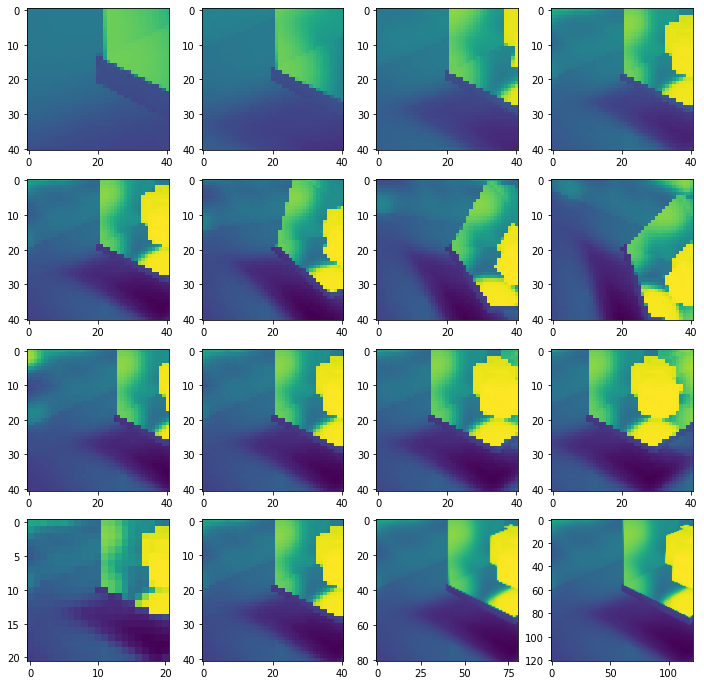

In [2]:
## Code for generating the figure of patches.
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.signal
from PIL import Image

def load_image(filepath):
    img = Image.open(filepath)
    return (np.asarray(img).astype(np.float)/255)[:, :, :3]

image = load_image("light_cubes_base.png")[:, :, 0]

# base_center_x = 800
# base_center_y = 600

# # You will use these values for your figure.
base_center_x = 500
base_center_y = 640

plt.figure(figsize=(12, 12))

# Loop over radius
for ind, rad in enumerate([25, 50, 75, 100]):
    plt.subplot(4, 4, 1+ind)
    plt.imshow(get_scaled_rotated_patch(
        image=image,
        feature_center_x=base_center_x,
        feature_center_y=base_center_y,
        feature_radius=rad,
        patch_radius=2*rad,
        feature_orientation=0.0,
        half_pixel_width=20),
              vmin=0, vmax=1)

# Loop over orientation
# (Remember that orientation is of the original feature)
for ind, th_deg in enumerate([0, 15, 30, 45]):
    th_rad = np.pi * th_deg / 180
    plt.subplot(4, 4, 5+ind)
    plt.imshow(get_scaled_rotated_patch(
        image=image,
        feature_center_x=base_center_x,
        feature_center_y=base_center_y,
        feature_radius=100,
        patch_radius=2*100,
        feature_orientation=th_rad,
        half_pixel_width=20))

    
# Loop over location
for ind, x_shift in enumerate([-50, 0, 50, 100]):
    plt.subplot(4, 4, 9+ind)
    plt.imshow(get_scaled_rotated_patch(
        image=image,
        feature_center_x=base_center_x + x_shift,
        feature_center_y=base_center_y,
        feature_radius=100,
        patch_radius=2*100,
        feature_orientation=0.0,
        half_pixel_width=20))
    
# Loop over resolution
# (Remember that orientation is of the original feature)
for ind, hpw in enumerate([10, 20, 40, 60]):
    plt.subplot(4, 4, 13+ind)
    plt.imshow(get_scaled_rotated_patch(
        image=image,
        feature_center_x=base_center_x,
        feature_center_y=base_center_y,
        feature_radius=100,
        patch_radius=2*100,
        feature_orientation=0.0,
        half_pixel_width=hpw))

## P3.2 Computing Homographies from Matches


### P3.2.1 Computing Homographies from Perfect Matches

In this problem, you will be computing homographies from feature matches that you generate by hand. This involves two steps:

1. Obtain feature matches between the two images. *For this question will be "computing" these matches by hand (you will do this automatically in another question). Most operating systems have an image inspection program that allows you to quickly get the coordinates of a pixel. Alternatively, you can use trial and error with the `visualize_matches` function I have provided for your convenience below.*
2. Compute the homography matrix $H$ using the procedure introduced in class. This means that you are trying to find a matrix $A$ that satisfies the following relation:

<img src="homography_slide_a.png" width="400">
<img src="homography_slide_b.png" width="400">

In the code block labeled `An example of match visualization` below, I have given you a full worked example of what this process will look like: I have generated an example transformed image using a known homography `H_known`, provided some `matches`, used those matches to compute the homography `H_computed` (using a function you will write), and then visualized the results using `visualize_computed_transform`. This is what a "correct solution" should look like.

**FIGURES** I have provided you with 6 images: `img_base` (the starter image in the code below), and 5 "transformed images", each with different homography matrices. For each "transformed image", manually identify at least four matches between it and the base image, use these matches to compute the homography $H$ and use the `visualize_compute_transform` function to generate a plot. Include these plots in your writeup. 

Your "reconstruction difference" plots are not expected to be perfect, but should be reasonably close to accurate; you will not be penalized for small differences. If the reconstructed image is completely different from the base image, you will be marked as incorrect.


In [3]:

def homography(matches):

    A = []
    for corr in matches:
        
        A_1 = [corr[0], corr[1],1, 0, 0, 0,
              -1* corr[2] * corr[0], -1* corr[2] * corr[1], -1 * corr[2]]
        A_2 = [0, 0, 0, corr[0], corr[1],1,
              -1* corr[3] * corr[0], -1 * corr[3] * corr[1], -1* corr[3]]
        
        A.append(A_1)
        A.append(A_2)
        
    matrixA = np.matrix(A)
    #svd
    u, s, v = np.linalg.svd(matrixA)
    h = np.reshape(v[8], (3, 3))
    #normalize
    h = (1/h.item(8)) * h
    
    return h



In [4]:
## Plotting and Helper Functions
def visualize_matches(img_a, img_b, matches, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
    
    sa = img_a.shape
    sb = img_b.shape
    sp = 40
    off = sa[1]+sp
    
    merged_imgs = np.zeros(
        (max(sa[0], sb[0]), sa[1]+sb[1]+sp),
        dtype=np.float)
    merged_imgs[0:sa[0], 0:sa[1]] = img_a
    merged_imgs[0:sb[0], sa[1]+sp:] = img_b
    ax.imshow(merged_imgs)
    
    for m in matches:
        ax.plot([m[0], m[2]+off], [m[1], m[3]], 'r', alpha=0.5)


def transform_image(image, tmat):
    import cv2
    return cv2.warpPerspective(
        image, 
        np.array(tmat).astype(float), 
        dsize=(image.shape[1], image.shape[0]))
i=0
def visualize_computed_transform(image_base, image_transformed, H, matches):
    fig = plt.figure(figsize=(8, 8), dpi=150)
    tmat = np.linalg.inv(H)
    image_rec = transform_image(image_transformed, tmat)
    
    # Plotting
    ax = plt.subplot(2, 1, 1)
    visualize_matches(image_base, image_transformed, matches, ax)
    plt.title('Base Images (with matches)')
    ax = plt.subplot(2, 2, 3)
    plt.imshow(image_rec, vmin=0, vmax=1)
    plt.title('Reconstructed Image')
    ax = plt.subplot(2, 2, 4)
    plt.imshow(image_base - image_rec, vmin=-0.3, vmax=0.3, cmap='PiYG')
    plt.title('Reconstruction Difference')
    plt.savefig(str(i)+"pic.eps", format='eps',bbox_inches = 'tight')
    
# Load the Images
#  Base Image

img_base = load_image('tr_base.png')[:, :, 0]
#  Transformed Images
img_tr = load_image('tr_translated.png')[:, :, 0]
img_ro = load_image('tr_rotated.png')[:, :, 0]
img_sa = load_image('tr_aspect_scaling.png')[:, :, 0]
img_ha = load_image('tr_homography_a.png')[:, :, 0]
img_hb = load_image('tr_homography_b.png')[:, :, 0]


imageArr = []
imageArr.append(img_tr)
imageArr.append(img_ro)
imageArr.append(img_sa)
imageArr.append(img_ha)
imageArr.append(img_hb)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

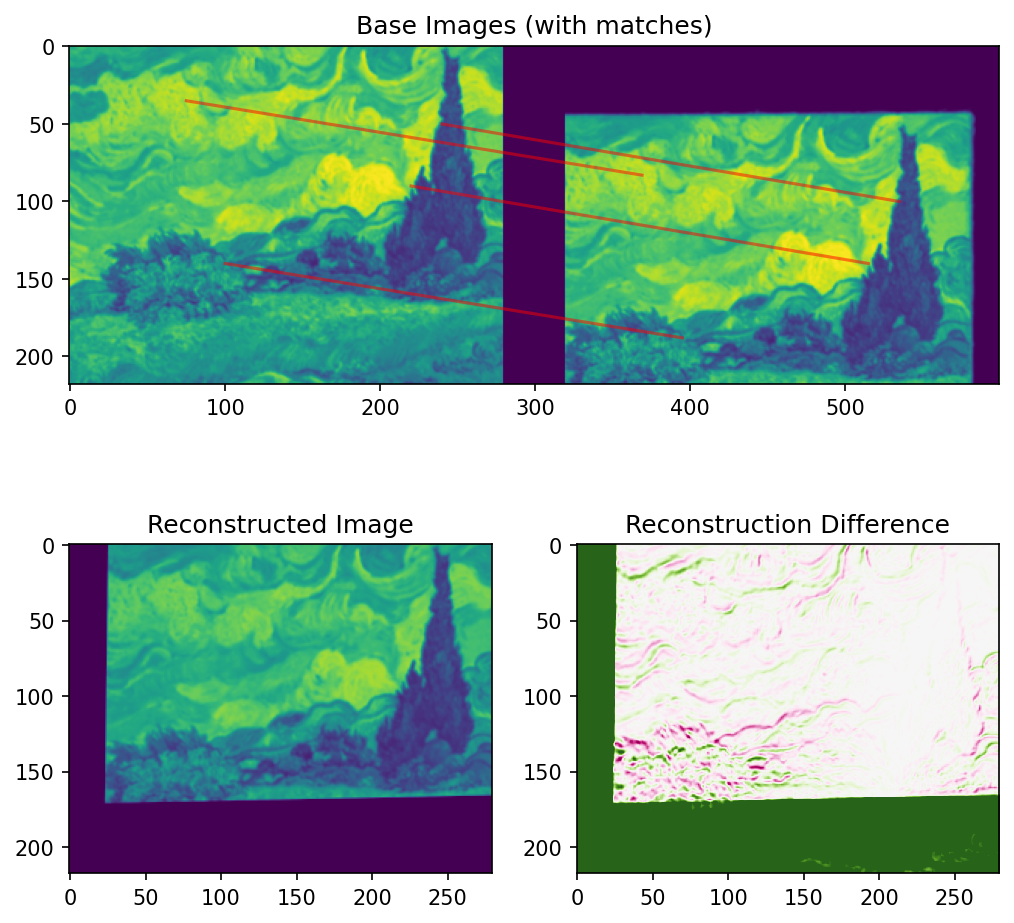

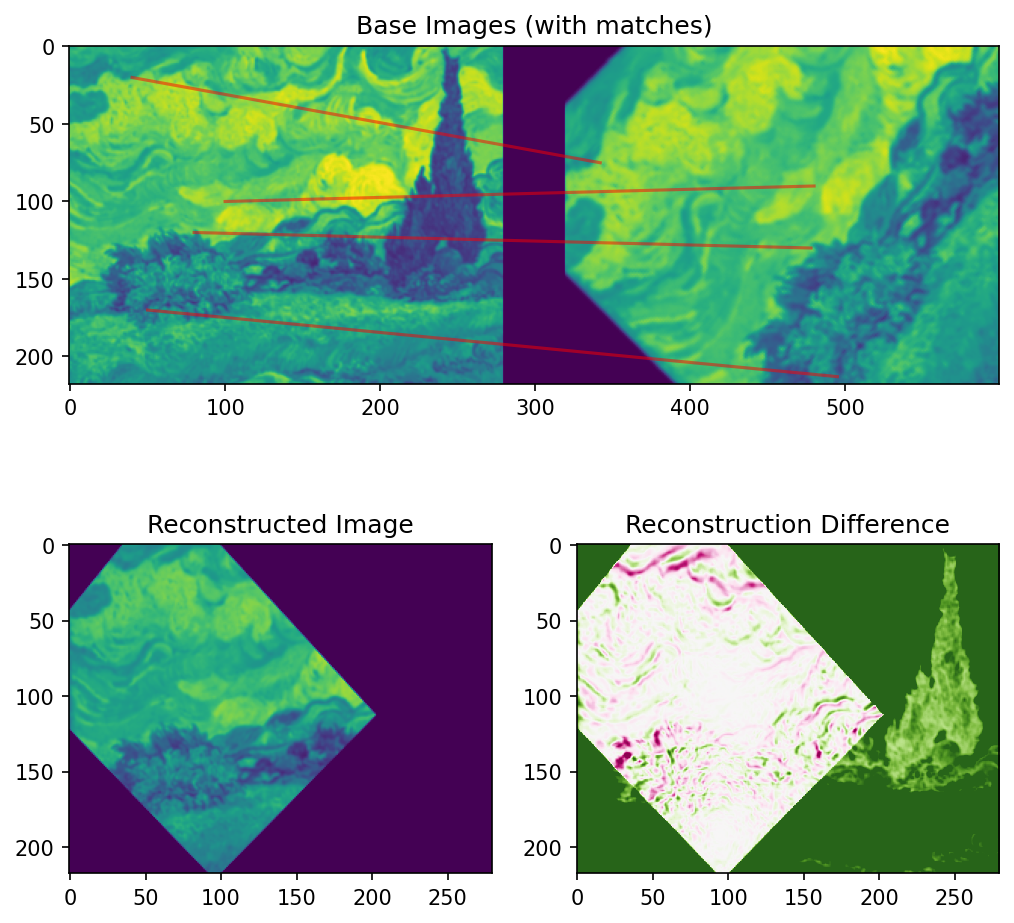

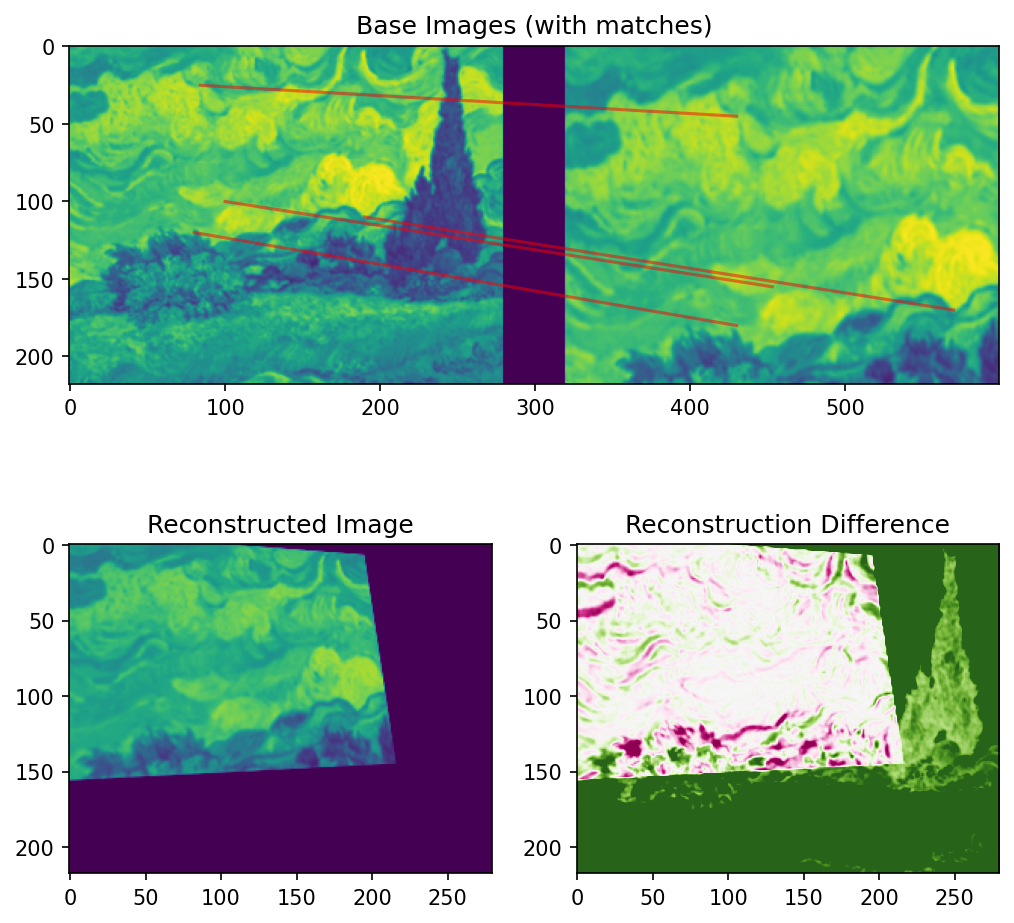

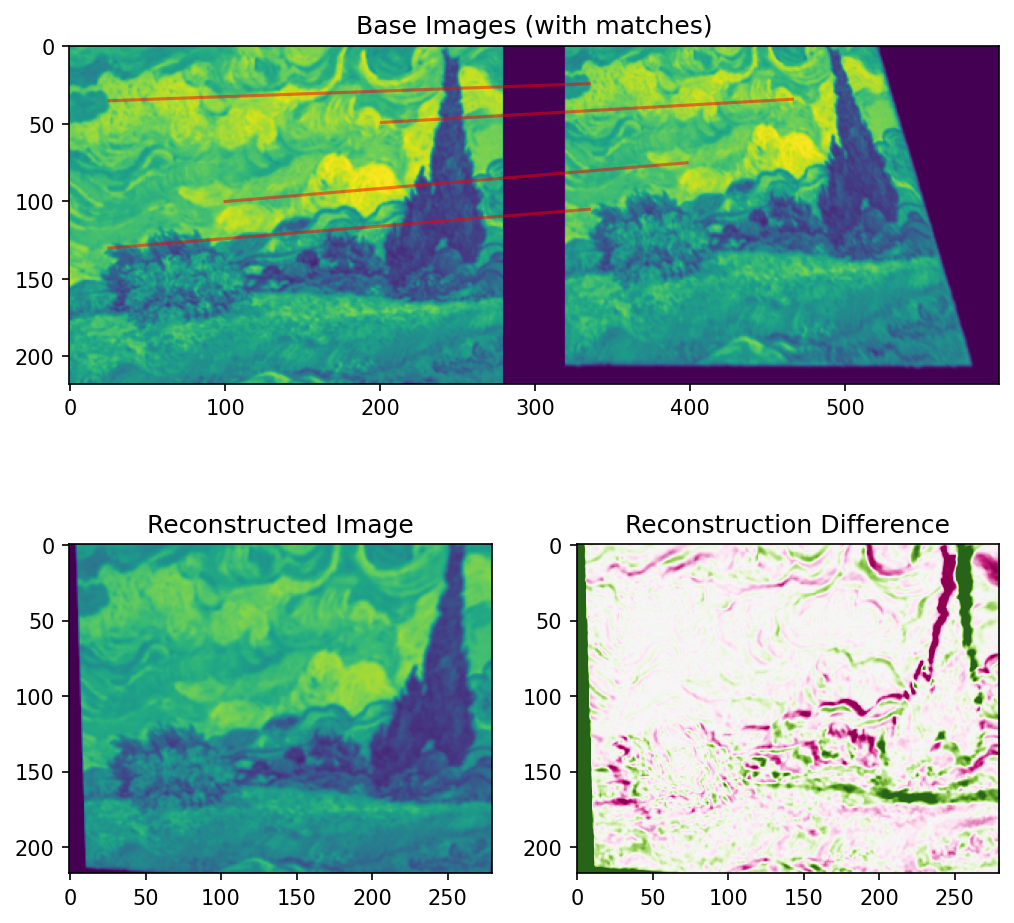

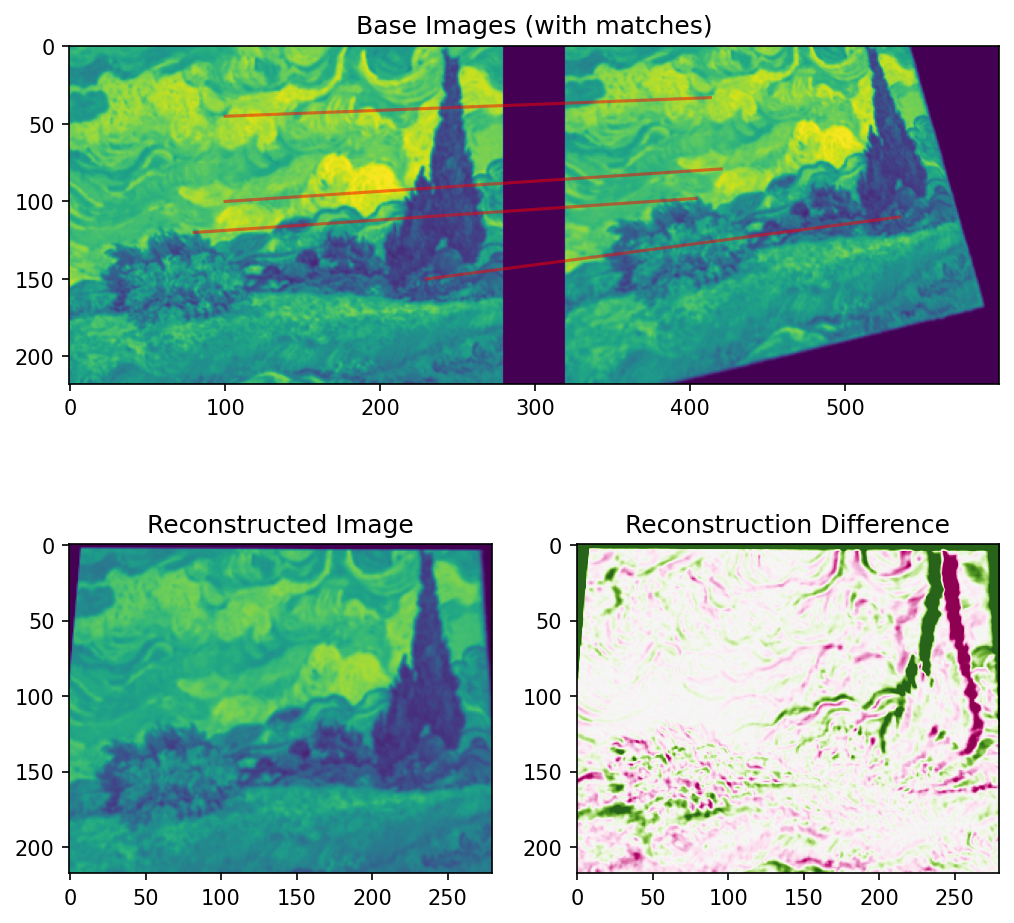

In [7]:
# An example of match visualization

# H_known = [
#     [1.2, 0, 0],
#     [0, 1.2, 0],
#     [0, 0, 1]
# ]

# img_example = transform_image(img_base, H_known)

# Matches Stored: [x1, y1, x2, y2]
# I computed these by inspection.
matches = [[30, 125, 36, 150],
            [20, 30, 25, 35],
            [80, 120, 96, 144],
            [220, 90, 264, 108]]


matches_tr = [[75, 35,49, 83],
                [240, 50, 215, 100],
                [100, 140, 75, 188],
                [220, 90, 195, 140]]

matches_ro= [[40, 20,22, 75],
            [50, 170, 175,213],
            [80, 120, 158, 130],
            [100, 100, 160, 90]]



matches_sa= [
    [84, 25,110, 45],
    [190, 110, 250, 170],
    [80, 120, 110, 180],
    [100, 100, 133, 155]
]



matches_ha= [
    [25, 35,15, 24],
    [25, 130, 15, 105],
    [201, 49, 146, 34],
    [100, 100, 78, 75]
]



matches_hb= [
    [100, 45,93, 33],
    [230, 150, 215, 110],
    [80, 120, 84, 98],
    [100, 100, 100, 79]
]


matchesArr = []
matchesArr.append(matches_tr)
matchesArr.append(matches_ro)
matchesArr.append(matches_sa)
matchesArr.append(matches_ha)
matchesArr.append(matches_hb)


for i in range(len(imageArr)):
    matches = matchesArr[i]
    img_example = imageArr[i]

    H_computed = homography(matches)

    visualize_computed_transform(
        img_base, img_example, H_computed, matches)

# This is what a "correct" H matrix looks like. In the region
# of the "Reconstruction Difference" where the transformed
# image was in view, the reconstruction is relatively small.
# Outside of that range, we do not know what the image looked
# like, and the reconstructed image is set to 0.

### P3.2.2 Computing Homographies from Noisy Matches

Now, I will ask you to compute the homography of a transform from a set of matches, where some of the matches are "outliers". The idea is that you will need to use RANSAC to compute which samples are inliers and which are outliers.

I have provided you with two sample images below (in `Noisy Matches Base Code`), and a set of matches. In the plot I have generated, you can see that though many of the matches are correct, there are a few outliers that will ruin the computation of the homography.

**FIGURE** Compute the homography with **all** of the `matches_noisy` I have provided and visualize using `visualize_computed_transform`. The resulting transform should be quite poor. Include this plot in your writeup.

Next, you will be implementing the RANSAC procedure we discussed in class and use it to compute a homography that is robust to the outlying detections. **Implement RANSAC procedure from class** and use this in combination with your `solve_homography` function to compute the homography despite outliers in `matches_noisy`. You will need a function that computes the inliers from the set of all matches and a proposed transformation matrix $H$. `matches_noisy` has a 10% outlier ratio. You should call your function `solve_homography_ransac(matches)`. You will need it again later. **Please include a code block containing your implementation of the RANSAC procedure in your report; it will help us give partial credit in the event that it does not appear to be working correctly.**

**RESULT** Include the computed homography matrix in your solution. Make sure the matrix is normalized such that the bottom right corner is equal to 1.

**FIGURE** Using `visualize_computed_transform`, visualize the transform you have computed using RANSAC and `matches_noisy`. Your solution should be quite accurate. If most of your `reconstruction_difference` plot is non-zero, something is probably wrong.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

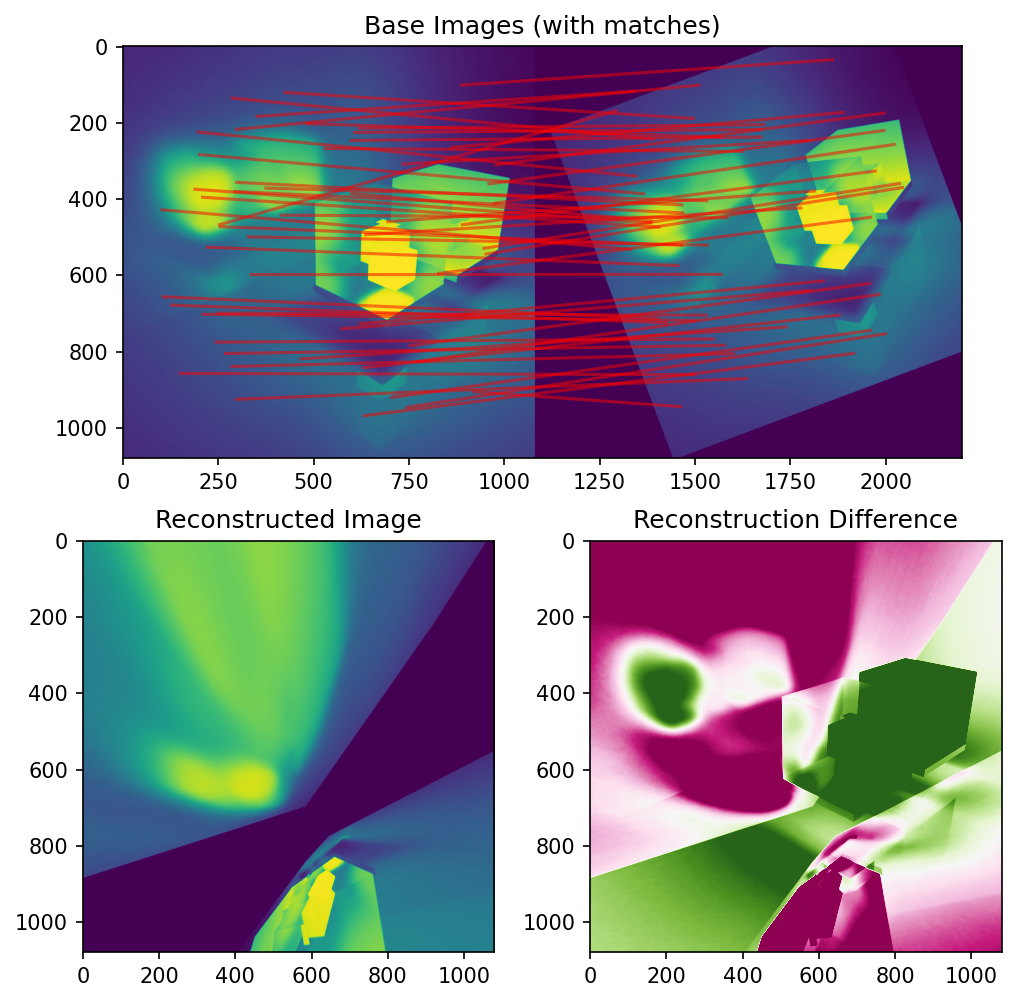

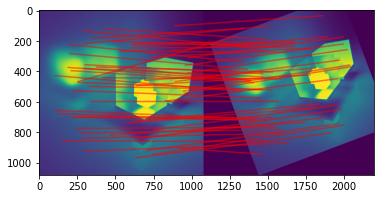

In [8]:
## Noisy Matches Base Code
img_base = load_image('light_cubes_base.png')[:, :, 0]
img_transformed = load_image('light_cubes_transformed.png')[:, :, 0]
matches_noisy = np.load('light_cubes_transformed_matches.npy')

h_noisy = homography(matches_noisy)
visualize_computed_transform(
    img_base, img_transformed, h_noisy, matches_noisy)


visualize_matches(img_base, img_transformed, matches_noisy)


def solve_homography_ransac(matches, rounds=100, sigma=5, s=4):
    raise NotImplementedError("Compute and return a 3x3 H matrix.")

In [9]:
def solve_homography_ransac(matches, rounds):
    in_max = []
    thresh = 10
    computedH = None
    for i in range(rounds):
        inliers = []
        #take 4 random points
        random_num = np.random.randint(low=0, high=len(matches), size=4)
        randomFour = matches[random_num]
        #calculate homography with those random point 
        
        h = homography(randomFour)

        for i in range(len(matches)):

            match =  matches[i]
            p1 = np.transpose(np.matrix([match[0], match[1], 1]))
            
            #our estimation with the homography
            estimatep2 = np.dot(h, p1)
            estimatep2 = (1/estimatep2.item(2))*estimatep2

            #Actual 
            p2 = np.transpose(np.matrix([match[2], match[3], 1]))

            # Error is the difference
            error = p2 - estimatep2

            dist = np.linalg.norm(error)
            if dist < 10:
                inliers.append(matches[i])

        if len(inliers) > len(in_max):
            in_max = inliers
            computedH = h
            
    return computedH

Computed Homography: [[ 8.00000000e-01  3.00000000e-01  1.04330073e-09]
 [-3.00000000e-01  8.00000000e-01  2.20000000e+02]
 [-3.33942755e-15 -3.24401534e-15  1.00000000e+00]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

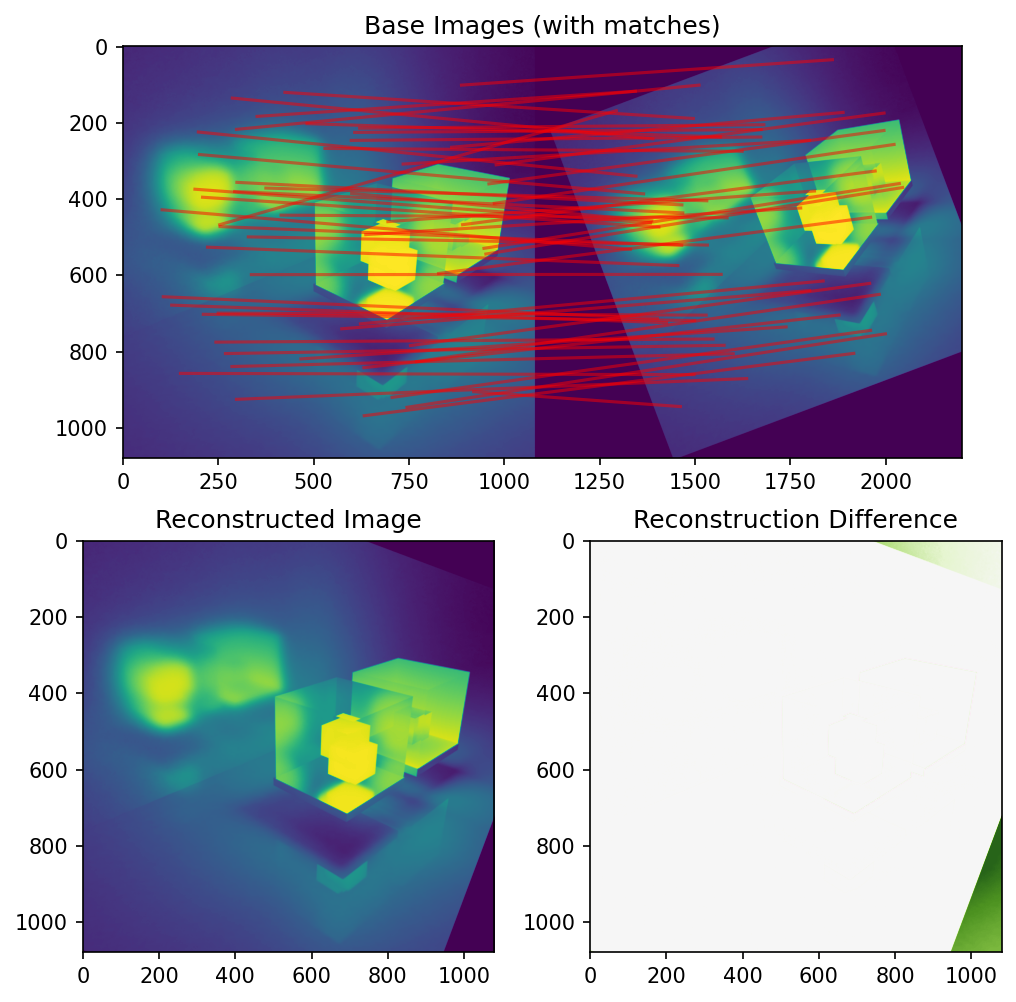

In [10]:
# Using your function, compute the homography and plot.
import random


H_robust = solve_homography_ransac(matches_noisy,100)
print(f"Computed Homography: {H_robust}")


visualize_computed_transform(
    img_base, img_transformed, H_robust, matches_noisy)

## 3.3 Feature Matching Pipeline

I have provided you with a function `compute_features_with_descriptors` which, well, computes features and their descriptors (via the `compute_scaled_rotated_patch` code you wrote earlier). However, the function is not quite complete, since it still needs a multi-scale feature detector. Fortunately, you wrote one of those in your last assignment:

**TASK** Define the function `compute_multi_scale_features` I have created in the `Code you need to provide` below. You can do this with the code you wrote for your last assignment. Notice that I have provided you with a `Feature` class in the code below. The `compute_multi_scale_features` function is expected to return a list of these `Feature` objects for the remainder of the code to work as expected.

To confirm that you are computing feature patches and orienting and scaling them correctly, it might be worth visualizing them (though you do not need to include these in your writeup). An example code snippet might look like:

```python
## Visualize Patches
sigmas = np.arange(5, 40.0, 1)
image = load_image('light_cubes_base.png')[::1, ::1, 0]
features = compute_features_with_descriptors(image, sigmas, 0.6)

# Plot a few of the feature patches for your own reference
# You should see that they are all aligned.
plt.figure()
for ind, f in enumerate(mfeatures[:9]):
    plt.subplot(3, 3, ind+1)
    plt.imshow(f.descriptor)
```

**TASK** Finally, implement the function `compute_feature_matches(fsa, fsb)`, which returns a list of matched feature pairs `[fa, fb]` from two lists of `Feature` objects. Once again, you should be using your feature descriptor matching code from the last assignment.

**FIGURE** I have included code under `Putting it all together` that, (1) computes features, (2) matches between them, (3) the homography to align the images, and (4) the plot showing the performance of the alignment. If you have finished implementing the previous functions, the final plot should show all the pieces working in harmony on the two transformed `sunflower` images I have provided! Run this code and include the resulting plot in your writeup, showing that you computed reasonable features/matches and the homography that aligns the images.

In [11]:
# Feature Matching Pipeline Helper + Plotting Code
class Feature(object):
    def __init__(self, x, y, radius):
        self.x = x
        self.y = y
        self.radius = radius
        self.descriptor = None
        
def plot_circ_features(image, features, ax):
    ax.imshow(image, cmap='gray')
    for f in features:
        cir = plt.Circle((f.x, f.y), f.radius, color='r', fill=False)
        ax.add_artist(cir)

def get_gaussian_filter(n, sigma=1):
    n = 2 * (n//2) + 1
    h = (n + 1)//2
    d = np.arange(h)
    d = np.concatenate((d[::-1], d[1:]))
    d = d[:, np.newaxis]
    d_sq = d**2 + d.T ** 2
    # Take the gaussian
    g = np.exp(-d_sq/2/(sigma**2))
    # Normalize
    g = g/g.sum().sum()
    return g

def compute_local_orientation(image, loc_x, loc_y):
    sobel_x = np.array([
      [1, 0, -1],
      [2, 0, -2],
      [1, 0, -1]
    ])

    sobel_y = np.array([
      [1, 2, 1],
      [0, 0, 0],
      [-1, -2, -1]
    ])
    
    ir = loc_y
    ic = loc_x
    Ix = scipy.signal.convolve(
        image, sobel_x, mode='same')
    Iy = scipy.signal.convolve(
        image, sobel_y, mode='same')
    return np.arctan2(Iy[ir, ic], Ix[ir, ic])

def compute_descriptor_for_feature(image, feature, half_pixel_width=5):
    """Gets descriptor patch for Feature object."""
    # Blur the image before computing orientation
    # and downsampling
    scale = feature.radius
    filt = get_gaussian_filter(5*scale, scale/half_pixel_width)
    scale_blurred_image = scipy.signal.convolve(
        image, filt, mode='same')
    
    filt = get_gaussian_filter(5*scale, scale)
    scale_blurred_image_more = scipy.signal.convolve(
        image, filt, mode='same')

        # Compute the orientation
    orientation = compute_local_orientation(
        scale_blurred_image_more, feature.x, feature.y)
    
    patch = get_scaled_rotated_patch(
        image=scale_blurred_image,
        feature_center_x=feature.x,
        feature_center_y=feature.y,
        feature_radius=feature.radius,
        patch_radius=2*feature.radius,
        feature_orientation=orientation,
        half_pixel_width=5)
    
    # Center and normalize patch
    return (patch - np.mean(patch))/np.std(patch)/np.prod(patch.shape)

def compute_features_with_descriptors(image, sigmas, threshold):
    features = compute_multi_scale_features(image, sigmas, threshold)
    array = []
    for feature in features:
           array.append({
            'x': feature[1],
            'y': feature[0],
            'r': np.sqrt(2)*sigmas[feature[2]],
            'descriptor': None,
        })
        
    for feature in array:
        feature['descriptor'] = compute_descriptor_for_feature(image, feature)
    return array

In [12]:
def get_LoG_filter(kernel_size, sigma):
    
    x = np.arange(-np.floor(kernel_size/2), np.floor(kernel_size/2)+1)
    y = np.arange(-np.floor(kernel_size/2), np.floor(kernel_size/2)+1)
    
    x_2d, y_2d = np.meshgrid(x, y)
    
    scaler = -1/ (np.pi * sigma**4)
    bracet = 1 - (np.square(x_2d)+np.square( y_2d))/ (2*np.square(sigma))
    expo = np.exp(- (np.square(x_2d)+np.square( y_2d))/ (2*np.square(sigma)))
    
    Normalize_LOG = scaler * bracet * expo * np.square(sigma)
    
    return x_2d, y_2d, Normalize_LOG


def get_local_maxima(data, threshold):
    # See: https://stackoverflow.com/a/9113227/3672986
    neighborhood_size = 3

    data_region_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_region_max)
    data_min = filters.minimum_filter(data, neighborhood_size)
    maxima[data < threshold] = 0

    labeled, num_objects = scipy.ndimage.label(maxima)
    slices = scipy.ndimage.find_objects(labeled)
    x, y, z = [], [], []
    for dy,dx,dz in slices:
        x_center = int(round((dx.start + dx.stop - 1)/2))
        x.append(x_center)
        y_center = int(round((dy.start + dy.stop - 1)/2))   
        y.append(y_center)
        z_center = int(round((dz.start + dz.stop - 1)/2))   
        z.append(z_center)
        
    return np.array(list(zip(x, y,z)))

In [13]:
## Feature Matching: Code to implement for P3.3
def compute_multi_scale_features(image, sigmas, threshold):
    response = np.zeros(
        [image.shape[0], image.shape[1], sigmas.size]
    )

    for ii, sigma in enumerate(sigmas):
        blob = apply_filter(circ_img,get_LoG_filter(2*np.ceil(sigma*3)+1,sigma)[2])
        response[:, :, ii] = np.abs(blob)
    coords = get_local_maxima(response, threshold)

    return coords

def compare_descriptors(fa, fb):
    """Computes matches between two lists of Feature objects.
    Returns a list of matched feature pairs, [fa, fb]"""
    return np.sum(fa['descriptor'] * fb['descriptor'])


def compute_feature_matches(fsa, fsb):
    # First compute the strength of the feature response
    sims = np.zeros((len(fsa), len(fsb)), dtype=np.float)
    for ii, fa in enumerate(fsa):
        for jj, fb in enumerate(fsb):
            sims[ii, jj] = compare_descriptors(fa, fb)

    # Now compute the matches
    matches = []
    for ii in range(len(fsa)):
        mi = np.argmax(sims[ii])
        if not ii == np.argmax(sims[:, mi]):
            continue
        match_score = sims[ii, mi]
        matches.append([fsa[ii]['x'],
                        fsa[ii]['y'],
                        fsb[mi]['x'],
                        fsb[mi]['y']])

    return matches


In [14]:
# Putting it all together
import time

start_time = time.time()

# Load the images
imagea = load_image('sunflowers_transformed_a.png')[:, :, 0]
imageb = load_image('sunflowers_transformed_b.png')[:, :, 0]

sigmas = np.arange(5, 31.0 ,5)
# Compute the features (with descriptors)
fsa = compute_features_with_descriptors(imagea, sigmas, 0.08)
fsb = compute_features_with_descriptors(imageb, sigmas, 0.08)

# Compute the matches
matches = compute_feature_matches(fsa, fsb)

# Convert to our other style of "matches"
# so that we can use the `solve_homography_ransac`
# function.
np_matches = np.array([
    [matche[0], matche[1], matche[2], matche[3]]
    for matche in matches])

# Solve for the homography matrix
H = solve_homography_ransac(np_matches,100)
print(f"Computed Homography: \n{H}")
print(f"Total Compute Time: {time.time() - start_time}")

# Visualize the results
visualize_computed_transform(
    imagea, imageb, H, np_matches)

NameError: name 'apply_filter' is not defined

## 3.4 Feature Matching with OpenCV

**Please do not attempt this question until the previous questions are completed; I would like you to try to get your system mostly working before trying a "professional" package.**

Follow the [OpenCV tutorial](https://docs.opencv.org/master/d1/de0/tutorial_py_feature_homography.html) to implement feature matching and computing homographies (copy-pasting code is expected here).

**FIGURE & DISCUSSION** Generate an image like the one in the tutorial but for the two transformed sunflower images I have included. How does the performance (e.g., in terms of the number of features or accuracy of matches) of the OpenCV system compare to the system you implemented? How much faster (roughly, I do not need a precise number) is the OpenCV system compared to yours?

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10
img1 = cv.imread('sunflowers_transformed_a.png',0)    # queryImage
img2 = cv.imread('sunflowers_transformed_b.png',0)    # trainImage

# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray')
plt.savefig("8pic.eps", format='eps',bbox_inches = 'tight')
plt.show()